In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn
import csv
import re

from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

from util.use_pickle import getDataFromPickleFN
from util.faded_lines import draw_faded_hline
from snsphd.viz import phd_style

colors, swatches = phd_style(jupyterStyle=True)

class pcrData_varThresh():
    def __init__(self, fn_light, fn_dark, bestThreshes=None):
        """


        :param fn_light: filename for light data
        :param fn_dark: filename for dark data
        :param bestThreshes: range of optimal threshold voltages [len(unique bias current), 2]
        """
        self.fn_light=fn_light
        self.fn_dark=fn_dark
        self.light_counts, self.biasCurrent, self.thresh, self.minPeak, self.p2p, self.times = self.loadData(self.fn_light, nSampsPerTrig=1)
        # This also set self.nTrig, self.biasR, self.expTime
        self.expTime*=self.nTrig
        self.dark_counts, _, _, _, _, _ = self.loadData(self.fn_dark)

        # units of Photons. Divide by self.expTime for flux
        total_light = np.sum(self.light_counts, axis=1)     # sum over 1000 triggers taken for each bias V
        total_dark = np.sum(self.dark_counts, axis=1)
        expTime_ratio = self.light_counts.shape[-1]/self.dark_counts.shape[-1]
        self.lightMinusDark = np.sum(total_light, axis=1) - np.sum(total_dark, axis=1)*expTime_ratio    #sum over number of samples in each trigger
        self.error = np.sqrt( np.sum(total_light, axis=1) + np.sum(total_dark, axis=1)*expTime_ratio**2 )


        #self.loadData(fn_light, fn_dark)
        if bestThreshes is None:
            bestThresh_low=self.chooseThresh(perc=0.4, minLight=1.5/self.expTime, maxDark=100.*self.nTrig/self.expTime)
            bestThresh_high = self.chooseThresh(perc=0.80, minLight=1.5 / self.expTime,maxDark=100. * self.nTrig / self.expTime)
            self.bestThreshes = np.array(list(zip(bestThresh_low, bestThresh_high)))
        else:
            self.bestThreshes = bestThreshes
        for t in self.bestThreshes: # make sure the low threshold is actually lower
            t[:]=[min(t),max(t)]

    def chooseThresh(self, perc=0.68, minLight=0, maxDark=10.E6):
        """
        Automatically find thresholds at around 'perc' of p2p value

        :param perc: percentage of p2p for threshold
        :param minLight: mask values that this much or less light during all trigger samples
        :param maxDark: mask values that have this much or more dark counts during any trigger sample
        :return:
            optimal list of thresholds for each unique bias current
        """

        # Get the unique bias current vs threahold
        x, inds = np.unique(self.biasCurrent, return_index=True)
        inds=np.sort(inds)          # Keep same order as we collected the data
        x=self.biasCurrent[inds]
        t = self.minPeak[inds] + (1. - perc) * self.p2p[inds]

        # Mask values that are too extreme
        minThresh = np.amin(self.thresh)
        maxThresh = np.amax(self.thresh)
        mask_2small = t<minThresh
        mask_2big = t>maxThresh

        # Mask out values that have atypical counts
        for i, b in enumerate(x):
            biasMask=self.biasCurrent==b
            if np.all(self.lightMinusDark[biasMask]<=minLight):
                mask_2small[i]=True
            if np.any(self.dark_counts[biasMask]>=maxDark):
                mask_2big[i]=True

        mask=np.logical_not(mask_2small) * np.logical_not(mask_2big)
        # Fit line to estimate the best threshold for each bias current (To smooth it out)
        if np.sum(mask) >= 2:  # need at least two good values to make a line
            slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], t[mask])
            t[mask] = slope * x[mask] + intercept


        # Find the nearest threshold actually measured to the optimal one for each bias current
        for i, b in enumerate(x):
            biasMask = self.biasCurrent == b
            availableThreshes = self.thresh[biasMask]
            idx = np.abs(availableThreshes - t[i]).argmin()
            t[i] = availableThreshes[idx]

        return t


    def loadData(self, fn, nSampsPerTrig=None):
        print("LOADING: "+fn)
        data = np.loadtxt(fn)
        if not hasattr(self, 'biasR') or not hasattr(self, 'expTime'):
            with open(fn, 'r') as fh:
                lineWasHeader=True
                while lineWasHeader and (not hasattr(self, 'biasR') or not hasattr(self, 'expTime')):
                    line = fh.readline()
                    lineWasHeader= line.strip().startswith("#") or line.strip()==''
                    if ("Bias Resistor".lower() in line.lower()):
                        self.biasR = float(re.sub("[^0-9\.]", "", line.split(":", 1)[1]))
                    if "Gate integration".lower() in line.lower():
                        self.expTime = float(re.sub("[^0-9^.]", "", line.split(":", 1)[1]))

        nDataPoints = len(np.unique(data[:, 0]))
        if not hasattr(self, 'nTrig'):
            self.nTrig = int(np.round((len(data) / nDataPoints / nSampsPerTrig)))
        else:
            nSampsPerTrig = int(np.round(len(data)/nDataPoints/self.nTrig))
        skipRows = self.nTrig*nSampsPerTrig
        biasCurrent = (data[::skipRows, 1] - data[::skipRows, 2]) / self.biasR
        times = data[::skipRows, 0]
        counts = np.reshape(data[:, 3], (len(biasCurrent), self.nTrig, nSampsPerTrig))
        #totalCounts = np.sum(counts, axis=1)
        thresh = data[::skipRows, 4]
        minPeak = data[::skipRows, 5]
        p2p = data[::skipRows, 6]

        x=np.unique(biasCurrent)
        print("\tNum points: "+str(len(times)))
        print("\tNum bias points: "+str(len(x)))
        #print("\tBias points: " +str(x*10**6))
        print("\tNum Triggers: "+str(self.nTrig))
        print("\tNum samples/trig: "+str(nSampsPerTrig))
        print("\tExptime: "+str(self.expTime*10**6)+" us")
        print("\tBias Resistance: "+str(self.biasR/1000)+" kOhms")

        return counts, biasCurrent, thresh, minPeak, p2p, times



def plot_pcr(
    fns,
    labels,
    ranges,
    start,
    stop,
    skip,
    legend_title='',
    maxDCR=None,
    plt_dark=None,
    manualScale=None,
    left_ymax: float = 1.0,
    right_top: float | None = None,
):
    """
    left_ymax controls the top of the left (linear) axis. The right (log) axis top
    is computed as 10 ** (5 * left_ymax) to preserve alignment so that
    0.0..1.0 on the left maps exactly to 10^0..10^5 on the right.

    Optionally, set right_top (e.g., 1.1e5). When provided, left_ymax is
    derived as log10(right_top)/5 to keep the mapping aligned and then used
    to set both axes. This lets you request a precise right-axis top while
    preserving the 6-decades-per-left-unit alignment.
    """

    right_axis_color = "#3054b8"

    if plt_dark ==None:
        plt_dark=[False]*len(fns)
        plt_dark[0]==True
    pal = seaborn.color_palette("rocket")
    colors_dark = [pal[0], pal[0], pal[0], pal[0], pal[0], pal[0]]

    colors_dark = [
        right_axis_color,
        right_axis_color,
        right_axis_color,
        right_axis_color,
    ]

    plasma_map = plasma_cmap = plt.cm.plasma
    colors = [plasma_map(0.1), plasma_map(0.5), plasma_map(0.8), plasma_map(1.0), plasma_map(1.0), plasma_map(0.99)]
    markers = ['o','^','D','h']
    markers_dark = ['x','h','D','h']

    fig, ax = plt.subplots(1,figsize = (7,4))
    ax_d = ax.twinx()
    ax.set_zorder(1)
    ax.patch.set_visible(False)

    # Determine if any dark data will be plotted
    has_dark = bool(np.any(plt_dark))

    # Configure right axis visibility and styling only when plotting dark data
    if has_dark:
        ax_d.spines['right'].set_visible(True)
        ax_d.spines['right'].set_linewidth(1.9)
        # ax_d.spines['right'].set_linestyle('--')
        ax_d.spines['right'].set_color(right_axis_color)
        ax_d.tick_params(axis='y', colors=right_axis_color)
    else:
        # Hide the entire right axis when no dark traces are requested
        ax_d.spines['right'].set_visible(False)
        ax_d.get_yaxis().set_visible(False)

    if maxDCR == None:
        maxDCR=[1.5*10**3]*len(fns)

    if manualScale == None:
        manualScale=[1]*len(fns)

    # We'll draw our own grids
    ax.grid(False)
    ax_d.grid(False)

    for i in range(len(fns)):
        data = getDataFromPickleFN(fns[i])
        expTime_i = pickle.load(open(fns[i], 'rb')).expTime
        if i==0 or expTime_i > expTime:
            expTime=expTime_i
        if plt_dark[i]:
            ax_d.plot(
                data[ranges[i], 0],
                data[ranges[i], 3],
                markers_dark[i],
                c=colors_dark[i+skip%len(colors_dark)],
                lw=3,
                markersize=4,
                label="DCR "+labels[i],
                alpha=0.6
            )
        m = np.amax(data[ranges[i], 1]) / manualScale[i]
        print(labels[i]+"; scale: "+str(m))
        ax.plot(
            data[ranges[i], 0],
            data[ranges[i], 1] / m,
            markers[i],
            c=colors[i+skip % len(colors)],
            lw=3,
            markersize=4,
            label=labels[i],
            alpha=0.6,
            linestyle='-',
        )

        bias = data[ranges[i], 0]
        counts = data[ranges[i], 1]
        dark = data[ranges[i], 3]

    # If a specific right-axis top is requested, derive left_ymax to preserve alignment
    if has_dark and right_top is not None:
        if right_top <= 0:
            raise ValueError("right_top must be > 0")
        left_ymax = np.log10(right_top) / 6.0

    # Labels and x-limits
    ax.set_xlabel(r"Bias Current ($\mu$A)",labelpad=10)
    ax.set_xlim([start,stop])
    ax.set_ylabel("Normalized Counts (a.u.)",labelpad=15)

    if has_dark:
        # ----- Coupled y-axes mapping with headroom -----
        # Left (linear): 0.0..left_ymax with major ticks every 0.2
        ax.set_ylim(0.0, left_ymax)
        ax.yaxis.set_major_locator(MultipleLocator(1/6))

        # Right (log): 10^0 .. 10^(6*left_ymax)
        ymin_r = 10 ** 0
        ymax_r = 10 ** (6 * left_ymax)
        ax_d.set_yscale("log")
        ax_d.set_ylim(ymin_r, ymax_r)

        # Powers-of-ten major ticks spanning current decades
        exp_min = int(np.ceil(np.log10(ymin_r)))
        exp_max = int(np.floor(np.log10(ymax_r)))
        pow_ticks = [10 ** e for e in range(exp_min, exp_max + 1)]
        if ymin_r == 1 and 1 not in pow_ticks:
            pow_ticks = [1] + pow_ticks
        ax_d.yaxis.set_major_locator(FixedLocator(pow_ticks))

        def _right_tick_formatter(y, pos):
            # Label only powers of ten in the 10eX style used in the notebook
            if y <= 0:
                return ""
            exp = np.log10(y)
            if np.isclose(exp, round(exp)):
                exp = int(round(exp))
                label_exp = exp - 1  # so 1 -> 10e-1, 10 -> 10e0, etc.
                s = f"10e{label_exp:+d}"
                return s.replace("+", "")
            return ""

        ax_d.yaxis.set_major_formatter(FuncFormatter(_right_tick_formatter))

        # Color right axis to match DCR
        ax_d.spines["right"].set_color(right_axis_color)
        ax_d.tick_params(axis="y", colors=right_axis_color)
        ax_d.yaxis.label.set_color(right_axis_color)

        # ----- Segmented, fading horizontal grid lines -----
        x0, x1 = ax.get_xlim()

        # Optional subtle anchors at 0.2, 0.4, 0.6, 0.8
        for y_lin in np.linspace(0, 1, 7):
            if y_lin <= left_ymax:
                xs = np.array([[x0, y_lin], [x1, y_lin]])
                lc = LineCollection([xs], colors=[mcolors.to_rgba("0.0", 0.25)], linewidths=0.5, zorder=0)
                ax.add_collection(lc)

        # Fade-right-to-left for right-axis log minor grid lines: y = (2..9) * 10^k
        ymin, ymax = ax_d.get_ylim()
        min_exp = int(np.floor(np.log10(ymin)))
        max_exp = int(np.floor(np.log10(ymax)))
        for k in range(min_exp, max_exp + 1):
            for m in range(2, 10):
                y_minor = m * (10 ** k)
                if ymin <= y_minor <= ymax:
                    draw_faded_hline(
                        ax_d,
                        y_minor,
                        x0,
                        x1,
                        n_segments=50,
                        base_color=right_axis_color,
                        alpha_max=0.2,
                        lw=0.5,
                        fade_from="right",
                        zorder=0.05,
                    )
    else:
        # No special left-axis coupling or anchors when no dark axis
        # Let Matplotlib autoscale; optionally anchor baseline at 0
        ax.grid()
        try:
            cur_bottom, cur_top = ax.get_ylim()
            ax.set_ylim(bottom=0)
        except Exception:
            pass

    if has_dark:
        ax_d.set_ylabel("Dark Count Rate (cps)")
    else:
        ax_d.get_yaxis().set_visible(False)

    # Build separate legends for PCR and DCR
    lines_pcr, labels_pcr = ax.get_legend_handles_labels()
    lines_dcr, labels_dcr = ax_d.get_legend_handles_labels()

    # Create PCR legend in upper left
    if lines_pcr:
        legend_pcr = ax.legend(
            lines_pcr, 
            labels_pcr, 
            loc='upper left', 
            # title=legend_title if legend_title else 'PCR',
            frameon=False, 
            fontsize=11
        )
        plt.setp(legend_pcr.get_title(), weight='bold')
        ax.add_artist(legend_pcr)  # Keep this legend when adding the second one

    # Create DCR legend in lower right
    if lines_dcr:
        legend_dcr = ax_d.legend(
            lines_dcr, 
            labels_dcr, 
            loc='center right', 
            # title='DCR',
            frameon=False, 
            fontsize=11
        )
        plt.setp(legend_dcr.get_title(), weight='bold')

    plt.tight_layout()

    return fig, ax, ax_d

    

    # with open('../out/29umdata.csv', 'w') as csvfile:
    #     csvwriter = csv.writer(csvfile)
    #     csvwriter.writerow(['bias uA','counts','darkcounts'])
    #     for i in range(len(bias)) :
    #         csvwriter.writerow([bias[i],counts[i],dark[i]])

<>:110: SyntaxWarning: invalid escape sequence '\.'
<>:110: SyntaxWarning: invalid escape sequence '\.'
/var/folders/9m/c8nsy0kn36s5ynk1dy_yxpv00000gn/T/ipykernel_36725/3225097650.py:110: SyntaxWarning: invalid escape sequence '\.'
  self.biasR = float(re.sub("[^0-9\.]", "", line.split(":", 1)[1]))


15$\mu$m; scale: 68857.33333333333
18$\mu$m; scale: 26292.0
29$\mu$m; scale: 40492.0


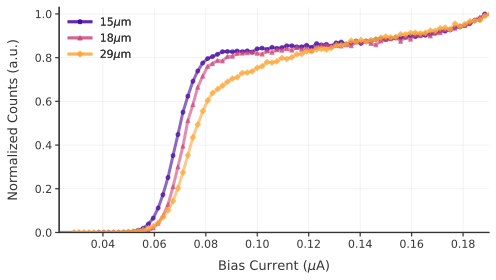

In [34]:
arrow = False
without_darkcount = True

if without_darkcount:
    arrow = False

fns = ['../data/Low_Tc_Dev3_80nm_Wire/pcrcurve_cr_20241209-145103.obj',
       '../data/Low_Tc_Dev3_80nm_Wire/pcrcurve_cr_20241209-135210.obj',
       '../data/Low_Tc_Dev3_80nm_Wire/pcrcurve_cr_20241209-141437.obj',
       ]
labels = [r"15$\mu$m", r"18$\mu$m", r"29$\mu$m"]
ranges = [range(0,80,1),range(0,86,1),range(0,86,1)]
limits_start = 0.023
limits_end = .19
skip = 0
fig, ax, ax_d = plot_pcr(fns,labels,ranges,limits_start,limits_end,skip,maxDCR = [100,300],plt_dark=[not without_darkcount] * len(fns), right_top=20e5)

# If the arrow is shown, move the right-axis (DCR) legend to the bottom-right
if arrow:
    right_axis_color_light = "#c2cdea"
    ax.annotate(
        "",
        xytext=(.43, 0.63),
        xy=(.49, 0.63),
        arrowprops=dict(
            arrowstyle="->", lw=3, mutation_scale=30, color=right_axis_color_light, alpha=1
        ),
    )
    leg_d = ax_d.get_legend()
    if leg_d is not None:
        leg_d.set_loc('lower right')

# Save after any annotation/legend adjustments so outputs reflect changes

st = "_arrow" if arrow else ""
sr = "_with_darkcount" if not without_darkcount else "_without_darkcount"

plt.savefig(f"../out/wire/Low_Tc_Dev3_80nm_Wire{st}{sr}.png", dpi=300)
# plt.savefig('../out/DEV2_2SNAP_PCRcurve_all.svg', dpi=300)
plt.savefig(f"../out/wire/Low_Tc_Dev3_80nm_Wire{st}{sr}.pdf", dpi=300)
############################################################################################################

a = 3